# Introduction

The goal of this project is to classify music genre according to a variety of other song features. The dataset is downloaded from https://www.kaggle.com/vicsuperman/prediction-of-music-genre, and the overall dataset is from Spotify, using the Spotify API. There are 10 genres represented, and the data is stored in an 8mb CSV file with 18 columns. It's actually not trivial to get documentation from Spotify on what each column means, so beyond what we have here we don't know much, so let's dive into it and see what we can find.

# Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pickle

# Importing the Data

In [2]:
filepath = "../data/music_genre.csv"
music_df = pd.read_csv(filepath)
music_df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [3]:
music_df.shape

(50005, 18)

Okay, great. We can confirm the 18 columns, and can see that we have 50,000 rows of music data. Each row appears to correspond with a song track, and we have a variety of data related to music such as duration, key, and tempo. We also see a bunch of other interesting metrics like popularity, danceability, and speechiness. We see a column labeled "instance_id", which might not be too useful for us, we'll see. Finally, we can also see some errors in the data already, like a track with a -1.0 ms duration or tempo with 14 decimal places of information. We'll probably want to clean these up.

# Cleaning the Data

In [4]:
music_df.dtypes

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
obtained_date        object
valence             float64
music_genre          object
dtype: object

Interesting. We can see that the datatype of the tempo column doesn't match with the majority of the data we can see within the column. Let's start investigating here.

In [5]:
music_df['tempo'].isna().sum()

5

This could be the reason that we see the object datatype. Let's see what we've got.

In [6]:
music_df[music_df['tempo'].isna()]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Okay, right off the bat there's just no information here. We can delete these rows, but this is also not likely what our problem is since containing a NaN value hasn't affected the datatype of the other columns. So let's identify what isn't numeric for tempo and go from there.

In [7]:
#dropping rows with missing data
na_index = music_df[music_df['tempo'].isna()].index
music_df.drop(index=na_index, inplace=True)

#checking out the tempo column
music_df['tempo_num'] = pd.to_numeric(music_df['tempo'], errors='coerce')
print(music_df['tempo_num'].isna().sum())
print(music_df['tempo'][music_df['tempo_num'].isna()].unique())

4980
['?']


Okay, so that is just completely unknown. Before we delete these values we'll have to see if they can be guessed from something else instead or our domain knowledge, but first let's make sure we sort out other erroneous data in the set, like the negative song durations.

In [8]:
print(music_df[music_df['duration_ms'] <= 0].shape)
print(music_df[music_df['duration_ms'] <= 0]['duration_ms'].unique())

(4939, 19)
[-1.]


So this is straightforward at least - in the two columns with erroneous data we have identified the form of the errors and have confirmed that they each take on a singular value. Now we need to see: do other columns have similar errors?

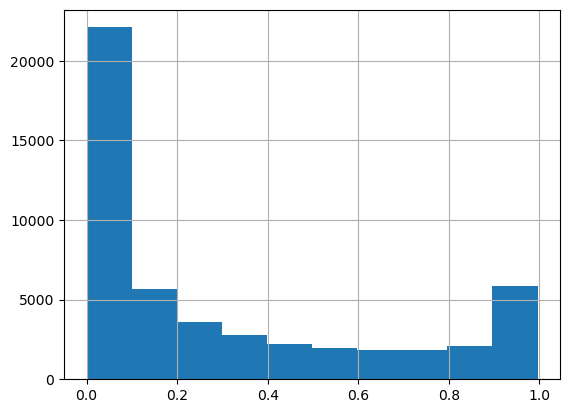

In [9]:
music_df['acousticness'].hist()
plt.show()

There a large bin at 0.0. Does this include 0.0 itself? How about 1.0? Would either of these values be chosen as a representation of lack of data?

In [10]:
music_df[music_df['acousticness'] <= 0.0]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,tempo_num
7952,49260.0,Yasuharu Takanashi,Haja no Senpuu,23.0,0.0,0.424,124427.0,0.912,0.775,C#,0.153,-4.929,Major,0.0371,85.01100000000001,4-Apr,0.0585,Anime,85.011


In [11]:
music_df[music_df['acousticness'] >= 1.0]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,tempo_num


Okay, this seems fine and our approach seems informative. Let's check out histograms of the other columns, at this point simply as a method of visualizing 50,000 rows for outlier quickly.

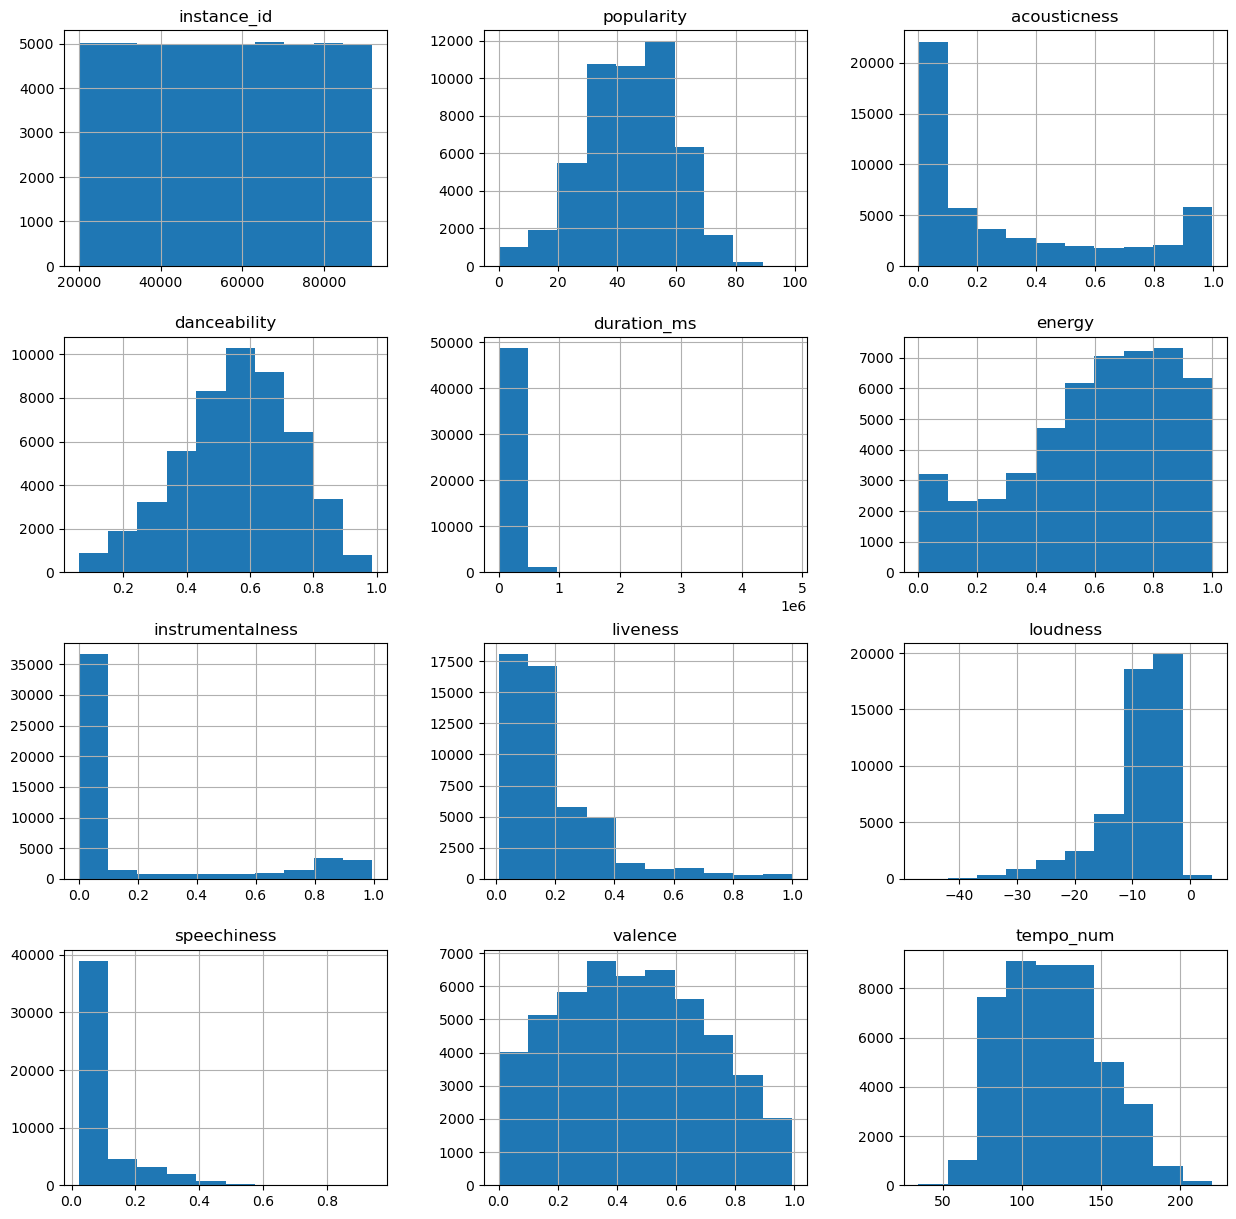

In [12]:
music_df.hist(figsize=(15, 15))
plt.show()

In general, these distributions look as expected. The metrics acousticness, danceability, energy, instrumentalness, liveliness, speechiness, and valence are distributed between 0 and 1, the presumable scale for these values. Likewise, popularity appears to exist on a scale of 0 to 100. Numeric tempo also seems more or less normally distributed now, so even though we need to decide what to do with missing values, we're looking good with the range of what we do have. However, two problems appear to still persist: the gigantic skew on duration_ms and what may be a possible positive loudness value, which seems like it may be impossible based upon my understanding of loudness. Let's investigate these two situations while also confirming the bounds of the scales mentioned above.

In [13]:
music_df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo_num
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,45020.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264,119.952961
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119,30.641701
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000,34.347000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000,94.941500
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000,119.879000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000,140.471250
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000,220.276000


We can confirm the range on most columns is as expected, and we know their datatypes are correct, so at this point it seems like we only need to address 3 things with respect to column data integrity: missing and suspicious values in the duration_ms column, missing values in the tempo column, and suspicious values in the loudness column.

In [14]:
music_df[music_df['duration_ms'] > 2000000]['duration_ms']

1410     4830606.0
2133     4497994.0
3759     4276000.0
4593     2764934.0
33508    2019293.0
42075    2294000.0
43868    3195440.0
Name: duration_ms, dtype: float64

In [15]:
print(music_df.iloc[1410])
print('\n')
print(music_df.iloc[1410]['duration_ms'] / 60000) #convert milliseconds to minutes

instance_id                     20911.0
artist_name                    Excision
track_name          Lost Lands 2017 Mix
popularity                         41.0
acousticness                    0.00164
danceability                      0.467
duration_ms                   4830606.0
energy                            0.948
instrumentalness                 0.0103
key                                  C#
liveness                          0.405
loudness                         -1.929
mode                              Major
speechiness                       0.299
tempo                                 ?
obtained_date                     4-Apr
valence                           0.317
music_genre                  Electronic
tempo_num                           NaN
Name: 1410, dtype: object


80.5101


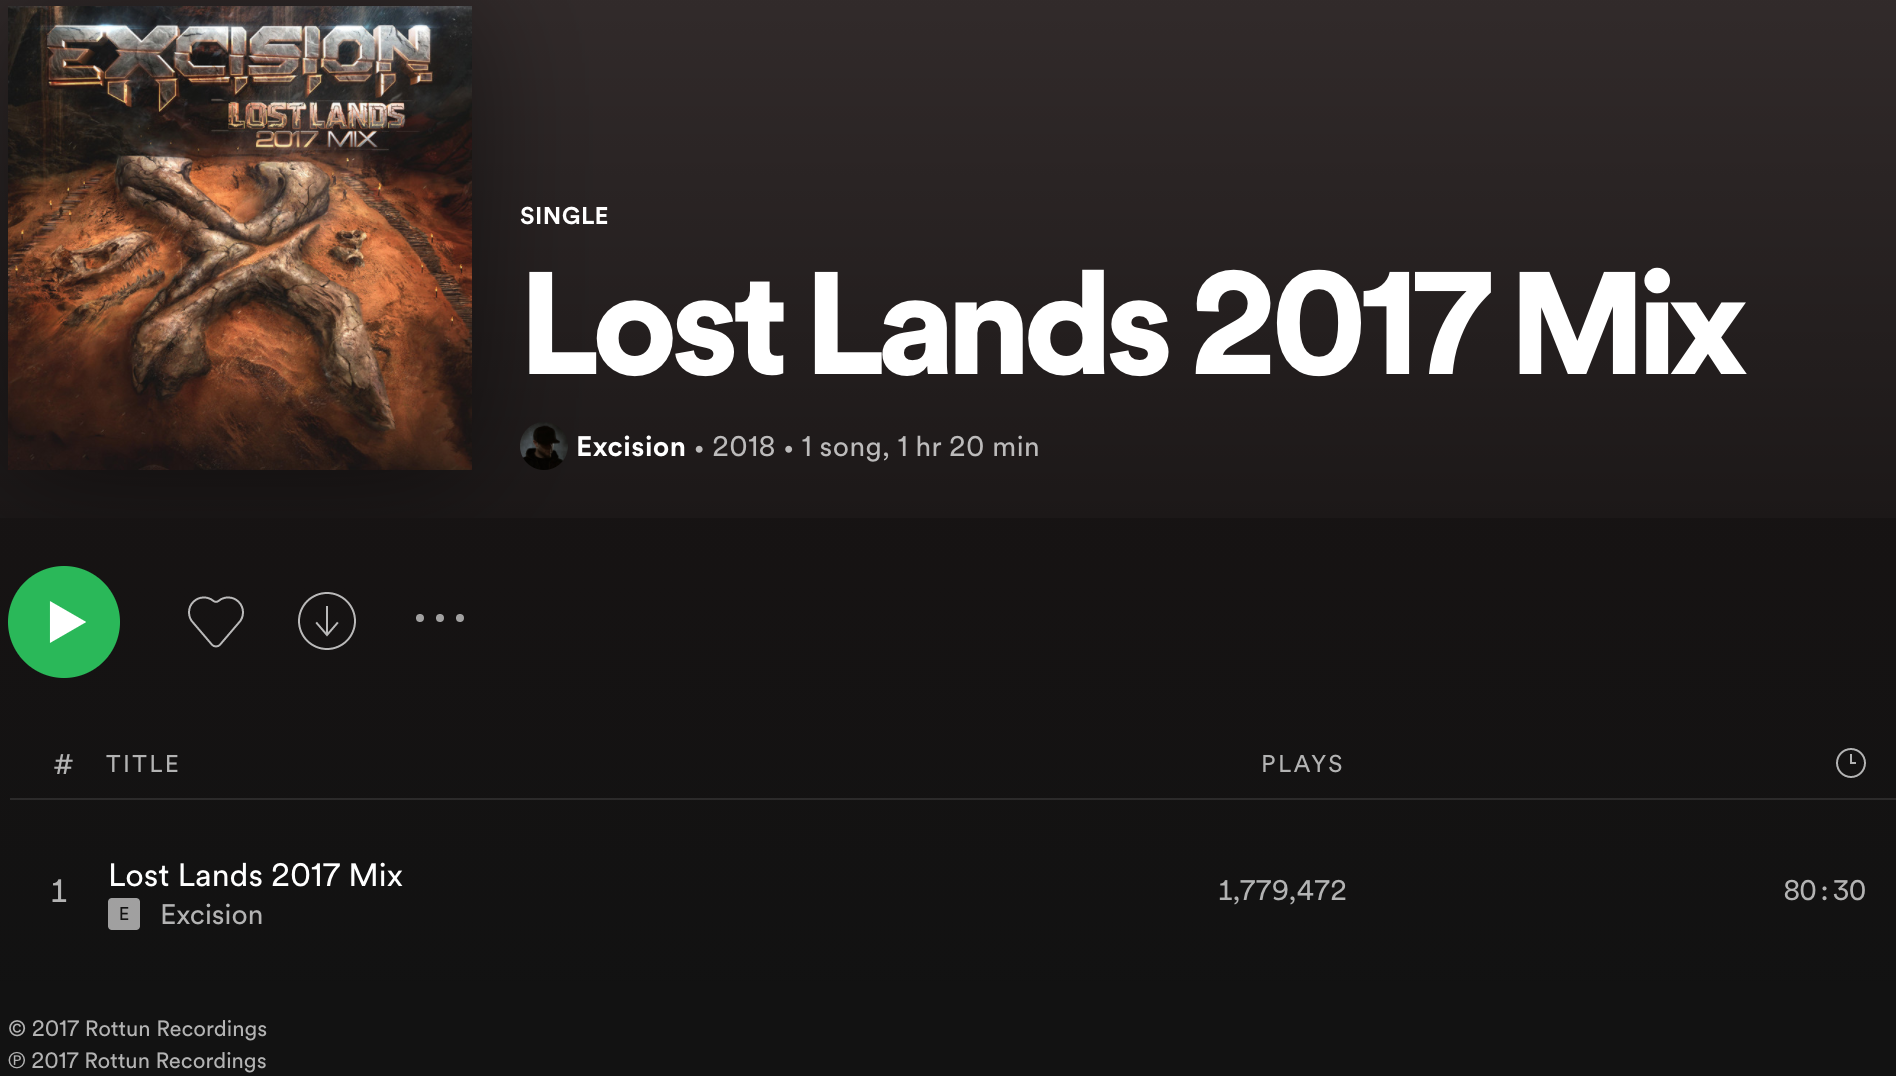

Apparently the long durations are real. Let's turn our focus to loudness.

In [16]:
music_df[music_df['loudness'] >= 0]['loudness'].unique()

array([0.072, 0.892, 0.598, 0.085, 0.004, 0.713, 0.423, 0.42 , 0.227,
       0.045, 0.483, 0.229, 0.594, 0.454, 1.314, 1.585, 0.034, 0.   ,
       0.203, 0.681, 0.118, 0.899, 0.35 , 0.73 , 0.188, 0.18 , 0.342,
       0.064, 0.455, 0.954, 0.241, 0.584, 1.61 , 0.222, 0.076, 1.893,
       0.359, 0.031, 0.125, 0.037, 0.674, 1.342, 0.878, 1.275, 3.744,
       1.949, 1.023, 1.012])

Well, there's not too many values here, and *perhaps* loudness can be positive due to positive gain as detailed [here](https://artists.spotify.com/help/article/loudness-normalization), so we can let these values remain in the data as well. Now, the only thing we're up against is the missing values.

In [17]:
music_df['duration_ms_pos'] = music_df['duration_ms'].replace(-1.,np.nan)
music_df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,tempo_num,duration_ms_pos
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic,100.889,NaN
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic,115.002,218293.0
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic,127.994,215613.0
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic,128.014,166875.0
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic,145.036,222369.0


In [18]:
music_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

Before we dive in with any imputation, let's see if tempo and duration values are relevant to genre. If they aren't, we might just want to drop this information completely, but it's conceivable that duration could trend with the 'Electronic' genre, as we saw above. 

In [19]:
music_df[['music_genre', 'tempo_num', 'duration_ms_pos']].groupby('music_genre').mean()

,tempo_num,duration_ms_pos
music_genre,,
Alternative,122.547235,233316.595697
Anime,126.799978,230705.681025
Blues,121.379962,253820.226699
Classical,104.053190,309661.894186
Country,123.784286,216899.031721
Electronic,125.930571,270703.431260
Hip-Hop,120.154134,219951.268071
Jazz,111.699415,264371.026205
Rap,120.585501,218927.021390


In [20]:
print(music_df['tempo_num'].mean())
print(music_df['duration_ms_pos'].median())

119.95296059529068
227360.0


For the most part, it seems like genres are fairly well in agreement in average tempo and duration, so seems like it would be reasonable to impute missing values based upon the mean tempo and median duration (due to the huge skew towards a few extremely long tracks). The only glaring misrepresentation appears to be tempo of the classical genre. Let's impute a test run, and see if it changes our summary statistics by a lot.

In [21]:
music_df['tempo_impute'] = music_df['tempo_num'].fillna(music_df['tempo_num'].mean())
music_df['duration_impute'] = music_df['duration_ms_pos'].fillna(music_df['duration_ms_pos'].median())
print(music_df[['music_genre', 'tempo_num', 'tempo_impute']].groupby('music_genre').mean())
print()
print(music_df[['music_genre', 'duration_ms_pos', 'duration_impute']].groupby('music_genre').mean())

              tempo_num  tempo_impute
music_genre                          
Alternative  122.547235    122.285214
Anime        126.799978    126.111168
Blues        121.379962    121.228699
Classical    104.053190    105.643167
Country      123.784286    123.390426
Electronic   125.930571    125.292162
Hip-Hop      120.154134    120.134821
Jazz         111.699415    112.490105
Rap          120.585501    120.522753
Rock         122.669614    122.431092

             duration_ms_pos  duration_impute
music_genre                                  
Alternative    233316.595697      232731.6580
Anime          230705.681025      230389.1796
Blues          253820.226699      251264.1688
Classical      309661.894186      301250.6406
Country        216899.031721      217928.3910
Electronic     270703.431260      266516.4558
Hip-Hop        219951.268071      220677.3238
Jazz           264371.026205      260692.1302
Rap            218927.021390      219790.5584
Rock           236833.312041      235

Ultimately, this seems reasonable for two reasons. First, we can see that imputing the values has not had a huge effect on the mean statistics of each genre, which is important as this is the quantity we are trying to predict. Second, from our knowledge about music, we know that within a genre it is possible to have songs of any length or speed. Adding back an average value for these parameters seems like it is still true to the subject matter while allowing us to also assess the other features. So now let's clean up our DataFrame.

In [22]:
music_df['tempo'] = music_df['tempo_impute']
music_df['duration_ms'] = music_df['duration_impute']
music_df.drop(columns=['tempo_num', 'tempo_impute', 'duration_ms_pos', 'duration_impute'], inplace=True)
music_df.shape

(50000, 18)

We're back to how we started, but cleaner. Let's check for duplicates.

In [23]:
music_df[music_df.duplicated()]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre


Lastly, I have a suspicion that instance_id and track_name are wholly unique.

In [24]:
print(music_df['instance_id'].nunique())
print(music_df['track_name'].nunique())

50000
41699


Instance_id is all unique, so we can drop this column, but track_name isn't. Let's probe more.

In [25]:
music_df[music_df['track_name'].duplicated(keep=False)].sort_values(by='track_name', axis=0)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
14829,77103.0,Lemon Jelly,'75 aka Stay With You,52.0,0.03070,0.712,371507.0,0.8270,0.795000,C#,0.122,-7.331,Major,0.0414,126.001000,4-Apr,0.305,Jazz
4096,71962.0,Lemon Jelly,'75 aka Stay With You,51.0,0.03070,0.712,371507.0,0.8270,0.795000,C#,0.122,-7.331,Major,0.0414,126.001000,4-Apr,0.305,Electronic
13660,29723.0,Jamiroquai,(Don't) Give Hate a Chance,48.0,0.01360,0.701,300227.0,0.8360,0.000081,D,0.197,-7.243,Major,0.0337,127.871000,4-Apr,0.812,Jazz
4030,20598.0,empty_field,(Don't) Give Hate a Chance,48.0,0.01360,0.701,300227.0,0.8360,0.000081,D,0.197,-7.243,Major,0.0337,127.871000,4-Apr,0.812,Electronic
31650,45147.0,Millie Jackson,(If Loving You Is Wrong) I Don't Want To Be Right,32.0,0.05590,0.519,237800.0,0.4580,0.000000,E,0.162,-11.702,Minor,0.0585,131.697000,4-Apr,0.328,Blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42701,62460.0,Joe Hisaishi,海の見える街 - スーパー・サウンド・コレクション Vol.2 魔女の宅急便組曲,38.0,0.96700,0.595,170827.0,0.2610,0.890000,E,0.353,-10.725,Minor,0.0258,119.952961,4-Apr,0.479,Classical
8331,36885.0,Nobuyuki Tsujii,花水木の咲く頃 - 辻井伸行,28.0,0.99400,0.270,209600.0,0.0171,0.921000,E,0.145,-31.429,Major,0.0410,70.931000,4-Apr,0.147,Anime
42383,24851.0,Nobuyuki Tsujii,花水木の咲く頃 - 辻井伸行,31.0,0.99400,0.270,209600.0,0.0171,0.921000,E,0.145,-31.429,Major,0.0410,70.931000,4-Apr,0.147,Classical
6249,80108.0,GReeeeN,道,29.0,0.24600,0.616,246453.0,0.9070,0.000000,A#,0.196,-4.650,Major,0.0387,94.970000,4-Apr,0.572,Anime


Uh oh. Two new observations have arisen, one possibly problematic: 'empty_field' in the artist_name column. We will have to investigate. Secondly, we see repeat instances of songs by the same artist where all the stats are the same, except popularity and music_genre, music_genre of course being the column of interest. Let's address this first. It seems we can use our domain knowledge here, which is that songs can often be categorized into multiple genres. In this way, we can maybe see already that 'popularity' may be a good indicator of genre. In the case of the artists Lemon Jelly and Nobuyuki Tsujii above, we can start to learn that perhaps 'Jazz' is more popular than 'Electronic' and that 'Classical' is more popular than 'Anime'. As such, it seems it makes sense to retain the duplicate tracks as we could conceivably gleam useful data.

The second thing to address is the missing artist names. It can be recognized that it's likely for an artist to stick to only one genre, and therefore if our model learns the associated genre for an artist it should be able to more easily ascribe that artist's genre to a new track in a testing set. However, we don't want to rely on this, as ideally our model is more robust than relying on having encountered a specific artist before. For this reason, we can decline using the artist name in our modeling, and just delete this column. Furthermore, while track name is ultimately not all unique, we have decided that we like the duplicates and otherwise will not rely on track name data.

In [26]:
music_df.drop(columns=['instance_id', 'artist_name', 'track_name'], inplace=True)

And what is the 'obtained_date' column?

In [27]:
music_df['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr', '0/4'], dtype=object)

This looks meaningless and is likely related to the creation of the dataset. Let's just delete it.

In [28]:
music_df.drop(columns=['obtained_date'], inplace=True)
music_df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,227360.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.002,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic


And lastly, we recognize that modeling tools will often need numeric info, even for categorical data, so we will [encode 'key' and 'mode'](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [29]:
key_encoder = LabelEncoder()
music_df['key'] = key_encoder.fit_transform(music_df['key'])

mode_encoder = LabelEncoder()
music_df['mode'] = mode_encoder.fit_transform(music_df['mode'])

And let's save our data for later.

In [30]:
#finalize DataFrame after the adjustments
music_df.reset_index(drop=True, inplace=True)

#paths to saved data files
data_path = '../data/processed/cleaned_data.pkl'
key_encode_path = '../encoders/key_encoder.pkl'
mode_encode_path = '../encoders/mode_encoder.pkl'

#saving data to the file system
music_df.to_pickle(data_path)
with open(key_encode_path, 'wb') as handle:
    pickle.dump(key_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(mode_encode_path, 'wb') as handle:
    pickle.dump(mode_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)